<a href="https://colab.research.google.com/github/sirknival/google-app-scripts/blob/main/plate_capacitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spslin

import matplotlib
import matplotlib.pyplot as plt

In [269]:
#Hier werden einige nuetzliche globale Variablen definiert

M=250 #Gitterpunkte entlang von x
N=251 #Gitterpunkte entlang von y

eps0=8.854e-12
U=1.0 #Elektrische Spannung zwischen den Platten

dx=dy=0.01 #Abstand der Gitterpunkte ist jeweils 1cm

#x,y Werte entlang des Gitters
x=np.arange(M)*dx
y=np.arange(N)*dy

#Erzeugen aller (x,y)-Wertepaare
X,Y=np.meshgrid(x,y)

#Dieses Hilfsfeld liefert über ind[ind_x, ind_y] den Index eines Volumens/Gitterpunktes 
#mit den Indices ind_x, ind_y innerhalb der Koeffizientenmatrix bzw. der Spaltenvektoren
ind=np.reshape(np.arange(M*N),(M,N)) 



In [270]:
#Diese Funktion erstellt die benoetigten Arrays zum Speichern von rho und A
def init_arrays():    
    #Vektor zum Speichern der Ladungsdichte bzw. zum Realisieren der Dirichlet-Randbedingungen
    rho=np.zeros(M*N) 
    
    #Matrix zum Speichern der Verknüpfungen zwischen den einzelnen Volumen
    A=sps.lil_matrix((M*N,M*N), dtype=float)
      
    return A, rho
    

In [271]:
B=sps.lil_matrix((3,3), dtype=float)

B[1,:] = 3
print(B)

  (1, 0)	3.0
  (1, 1)	3.0
  (1, 2)	3.0


In [272]:
#Die hier definierten Funktionen setzen die entsprechenden Werte 
#in der Koeffizientenmatrix A bzw. dem Spaltenvektor rho 

#Funktion zum Setzen der Koeffizientenmatrix A für ein leeres Simulationsgebiet
#mit homogenen Neumann-Randbedingungen am Rand des Gebiets
def set_laplace(A):
    #Implementieren Sie diese Funktion
    for x in range(M):
      for y in range(N):
        volums = 0
        if x < M-1:
          A[ind[x,y], ind[x + 1,y]] = -1 * eps0 / (dx**2)
          volums +=1
        if x > 0:
          A[ind[x,y], ind[x - 1,y]] = -1 * eps0 / (dx**2)
          volums +=1
        if y < N-1:
          A[ind[x,y], ind[x, y + 1]] = -1 * eps0 / (dx**2)
          volums +=1
        if y > 0:
          A[ind[x,y], ind[x, y - 1]] = -1 * eps0 / (dx**2)
          volums +=1

        A[ind[x,y], ind[x,y]] = volums * eps0 / (dx**2) 

            
#Diese Funktion modifiziert A und rho derart, dass eine parallel zur x-Richtung 
#liegende Metallplatte mit einem Potential pot ins Simulationsgebiet eingebracht wird
#Die Position der Platte wird dabei durch die Indizes in x-Richtung und den Index in y angegeben
def set_plate(indices_x, ind_y, pot, A, rho):
    #Implementieren Sie diese Funktion
    for ind_x in indices_x:
      
      A[ind[ind_x,ind_y],:] = 0
      A[ind[ind_x,ind_y], ind[ind_x,ind_y]] = 1
      rho[ind[ind_x, ind_y]]= pot
    

#Diese Funktion bestimmt die Gesamtladung an einer Platte (gegeben durch indices_x und ind_y)
def get_charge(indices_x, ind_y, phi):
    #Implementieren Sie diese Funktion
    Q_total = 0
    for ind_x in indices_x:
      Q_total += eps0 * (4*phi[ind[ind_x, ind_y]]-phi[ind[ind_x+1, ind_y]]-phi[ind[ind_x, ind_y+1]]-phi[ind[ind_x-1, ind_y]]-phi[ind[ind_x, ind_y-1]])
    return Q_total
            

In [273]:
#Diese Funktion loest nun das Gleichungssystem und gibt
#das Potential als Spaltenvektor zurueck

def solve(A,rho):
    A=sps.csr_matrix(A) #Erzeugen einer duennbesetzten Matrix vom Typ CSR
    phi=spslin.spsolve(A,rho) #Loesen des Gleichungssystems
    
    return phi

In [274]:
#Diese Funktion plottet das Potential (gegeben als Spaltenvektor) 
#und die Aequipotentiallinien
#Rho wird hier nur verwendet, um die Platten einzuzeichnen
#levels ist die Anzahl der Isolinien, die gezeichnet werden sollen
def plot_phi(phi, rho, levels=19):
    phi2d=np.reshape(phi,(M,N))
    rho2d=np.reshape(rho,(M,N))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    ax.pcolor(X,Y,phi2d.T,cmap="coolwarm")
    ax.contour(X,Y,phi2d.T,colors="black", levels=levels, linewidths=0.5, linestyles="-")

    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
    cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black],512)
    ax.pcolor(X,Y,np.abs(rho2d).T,cmap=cmap_rb)
    
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")

    plt.show()

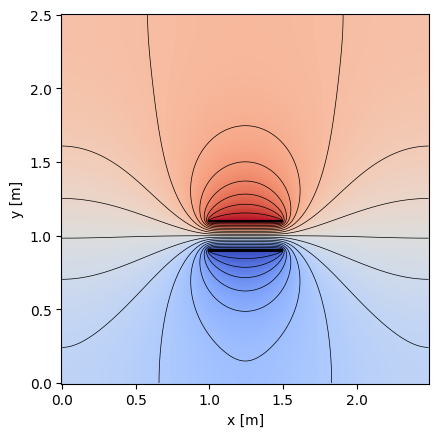

Lower plate charge
-3.3187046056818324e-11
Upper plate charge
3.318704605681927e-11
Capacity calc formula
6.640499999999999e-11


In [275]:
#Hauptteil des Programms
A, rho = init_arrays()

x_lower_plate = 100
x_length = 50
x_upper_plate = 100

#Definition der unteren Platte über die x,y Indizes
lower_plate_x_range=np.arange(x_lower_plate, x_lower_plate+ x_length)

lower_plate_y=90

#Definition der oberen Platte über die x,y Indizes
upper_plate_x_range=np.arange(x_upper_plate, x_upper_plate+ x_length)
upper_plate_y=110

#Setzen der Koeffizienten-Matrix A und des Spaltenvektors rho
set_laplace(A)
set_plate(lower_plate_x_range, lower_plate_y, -U/2, A, rho)
set_plate(upper_plate_x_range, upper_plate_y, +U/2, A, rho)

phi=solve(A, rho)
plot_phi(phi, rho)
print("Lower plate charge")
print(get_charge(lower_plate_x_range,lower_plate_y, phi))
print("Upper plate charge")
print(get_charge(upper_plate_x_range,upper_plate_y, phi))
print("Capacity calc formula")
print(eps0 / (upper_plate_y-lower_plate_y)*(x_upper_plate+x_length))

